In [21]:
import ERFutils
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

model_set = ERFutils.model_set
output_path = ERFutils.path_to_ERF_outputs
A = ERFutils.A


In [19]:
save = False

train = '1pctCO2'

# Import Green's Functions
G_ds_path = f'{output_path}GFs/G_loess_man_{train}_ERF_mean_ds.nc4'
G_ds = xr.open_dataset(G_ds_path)['G[tas]']

G_ds.name = 'G[tas]'
G_ds = G_ds.rename({'year':'s'})

In [31]:
N_years = 100
years = np.linspace(start=0, stop=N_years-1, num=N_years)
toy_ERF_paths = {}
toy_ERF_paths['linear'] = np.linspace(start=0, stop=5, num=N_years)
toy_ERF_paths['exponential'] = np.logspace(start=0, stop=3.5, num=N_years, endpoint=True, base=2.0) - 1
toy_ERF_paths['overshoot'] = -3*np.square(years)/4000 + 19*years/200


Text(0.5, 0, 'Year')

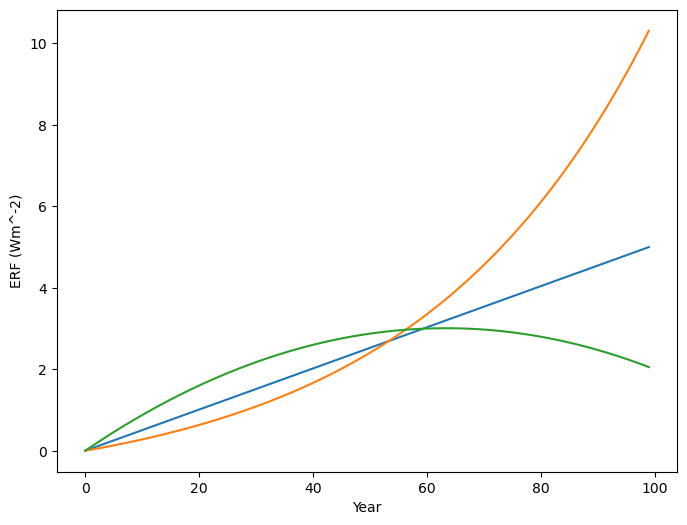

In [32]:
fig, ax = plt.subplots(figsize=(8,6))
for path in toy_ERF_paths.keys():
    ax.plot(toy_ERF_paths[path])
    
ax.set_ylabel('ERF (Wm^-2)')
ax.set_xlabel('Year')

In [22]:
def convolve_temp(G_ds, ERF_ds, train, conv_mean = True):
    if conv_mean:
        G_ds = G_ds.weighted(A).mean(dim = ['lat','lon'])

    GF = G_ds
        
    conv = {} 
    if conv_mean:
        print(f'Convolving mean GF for Global Mean')
        conv[train] = signal.convolve(np.array(GF.dropna(dim = 's')),
                                            np.array(ERF_ds),'full')
        conv[train] = ERFutils.np_to_xr_mean(conv[train], GF, ERF_ds)

    else:
        print(f'Convolving mean GF Spatially')
        conv[train] = signal.convolve(np.array(GF.dropna(dim = 's')), 
                                       np.array(ERF_ds)[~np.isnan(np.array(ERF_ds))][..., None, None],
                                       'full')
        conv[train] = ERFutils.np_to_xr(conv[train], GF, ERF_ds)
        
    length = max(len(GF.dropna(dim = 's')['s']),len(np.array(ERF_ds)))
    conv[train] = conv[train][:length]
    
    conv_ds = ERFutils.concat_multirun(conv,'train_id')

    return conv_ds

In [23]:
conv_mean_ds = {}
conv_ds = {}
for path in toy_ERF_paths.keys():
    conv_mean_ds[path] = convolve_temp(G_ds, toy_ERF_paths[path], train, conv_mean = True)
    conv_ds[path] = convolve_temp(G_ds, toy_ERF_paths[path], train, conv_mean = False)

Convolving mean GF for Global Mean
Convolving mean GF Spatially
Convolving mean GF for Global Mean
Convolving mean GF Spatially
Convolving mean GF for Global Mean
Convolving mean GF Spatially


Text(0.5, 0, 'Year')

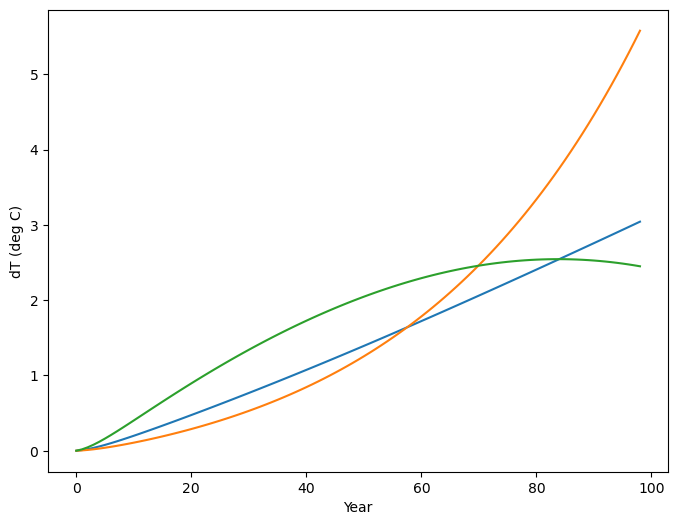

In [33]:
fig, ax = plt.subplots(figsize=(8,6))
for path in toy_ERF_paths.keys():
    ax.plot(conv_mean_ds[path][0][0:N_years-1])
    
ax.set_ylabel('dT (deg C)')
ax.set_xlabel('Year')

Text(0.5, 0, 'dT_global (deg C)')

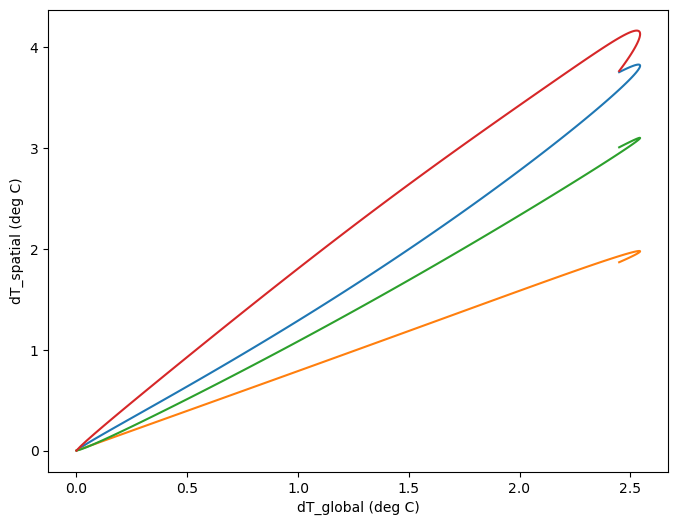

In [36]:
lat_lon = [(-20.5, 21),(7.5, 134),(3.5,287),(63.5,210)]
labels = ['Kalahari Desert','Palau']

fig, ax = plt.subplots(figsize=(8,6))
for lat, lon in lat_lon:
    ax.plot(conv_mean_ds['overshoot'][0][0:N_years-1],conv_ds['overshoot'].sel(lat=lat,lon=lon)[0][0:N_years-1])
    
ax.set_ylabel('dT_spatial (deg C)')
ax.set_xlabel('dT_global (deg C)')